In [1]:
#modeling sky subtraction model vs data points for 5/19/17 night
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

#plt.rcParams['image.interpolation'] = 'none'
#plt.rcParams['figure.figsize'] = (16, 10)

### amending below code to get sky subtraction seperate from 1d extraction for target

In [3]:
#flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
#          reduce_dblspec.find_all_obj(flatid,'DoubleSpec/20170519/red*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
#nfl = reduce_dblspec.create_normalized_flat(flats)
    
#header = atlasfiles[0].header    


    
    #locating all files w/ the target & flat/overscan subt
#specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
#          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files_target)]
    
    
#print("This is lenspecs:",len(specs))


    
    
    #stacking all that data for specific target-help increase s/n 
#comb = reduce_dblspec.combine_imgs(specs)
    
    
    
########'''  
    
def sky_subtract(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
#using#def _linfit(model, x, y):
    # used inside subtract_sky to fit a linear model to the sky, which is
    # much faster

    #x = np.array(x, copy=False)
    #y = np.array(y, copy=False)

    #xb = np.mean(x)
    #yb = np.mean(y)
    #slope = (np.mean(x * y) - xb * yb) / (np.mean(x**2) - xb**2)
    #intercept = yb - slope * xb
    #return model.__class__(slope=slope, intercept=intercept)
    else:
        print ("Model type or polynomial degree not recognized")
    
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


  



def show_image(self, **kwargs):
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)

            rescaleddata = ((self.data - mi) / (mx - mi))
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0

            d = np.log10(rescaleddata*99.+1.)
        else:
            d = self.data

        if kwargs.pop('transpose'):
            d = d.T

        res = plt.imshow(d, **kwargs)
        return res
    
    
    
#    plt.subplot(211)
#    plt.title('2D spec - Verify skyaps for correct target extraction')
#    if header['IRAFNAME']=='FeAr.spec': #blueside
#        print('choose 2D spec for blueside')
#        subimg.show_image(transpose=True,vmax=vmax,vmin=vmin) #replace as vmax=40,vmin=-10 if this doesnt work out well
#    elif header['IRAFNAME']=='henear.spec': #redside
#        print('choose 2D spec for redside')
#        subimg.show_image(transpose=False,vmax=vmax,vmin=vmin) #also replace here if doesnt work
#    else:
#        print("camera side for 2D spec not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")    
    
 
    #setting up 1D extraction of target
    #setting up extraction range based on sky apps not sure if these is good to do b/c depends on extension of gal size
    ##begin = (skyaps[0][0] + 60)
    ##print ('this is beginning value of target spec extraction:',begin)
    ##end = (skyaps[1][0] - 30)
    ##print('this is end value of target spec extraction:',end)
    ##flux, unc = subimg.extract_spectrum((begin,end))



    
def target_1d(subimg,specaps,ds):    
    flux, unc = subimg.extract_spectrum(specaps)
    

    
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])
    return (flux, unc)

#plt.subplot(212)
#plt.plot(comb.data[1])
#plt.plot(subimg(newdata))

In [4]:
flatid = 'DomeFlat'
atlasfiles = fits.open('henear.fits')
##targetID='68298203070473-ScoobyDoo'
##all_side_files_target='DoubleSpec/20170519/red*.fits' 
targetID = '79005021831220-Catch22'
all_side_files_target = 'DoubleSpec/20170518/red*.fits'

flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,'DoubleSpec/20170518/red*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
nfl = reduce_dblspec.create_normalized_flat(flats)
    
header = atlasfiles[0].header    


    
    #locating all files w/ the target & flat/overscan subt
specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files_target)]
    
    
print("This is lenspecs:",len(specs))


/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


This is lenspecs: 5


In [5]:
        #stacking all that data for specific target-help increase s/n 
comb = reduce_dblspec.combine_imgs(specs)
skyaps=[(20,33),(265,320)]#[(55,120),(190,350)] #target 35-260
#skyaps=[(30,110),(180,400)] 
model=('poly',2)

subimg2, comb2, fitmodels = sky_subtract(comb,skyaps,model)
#subimg2 is subtracted?
#comb2 is original?

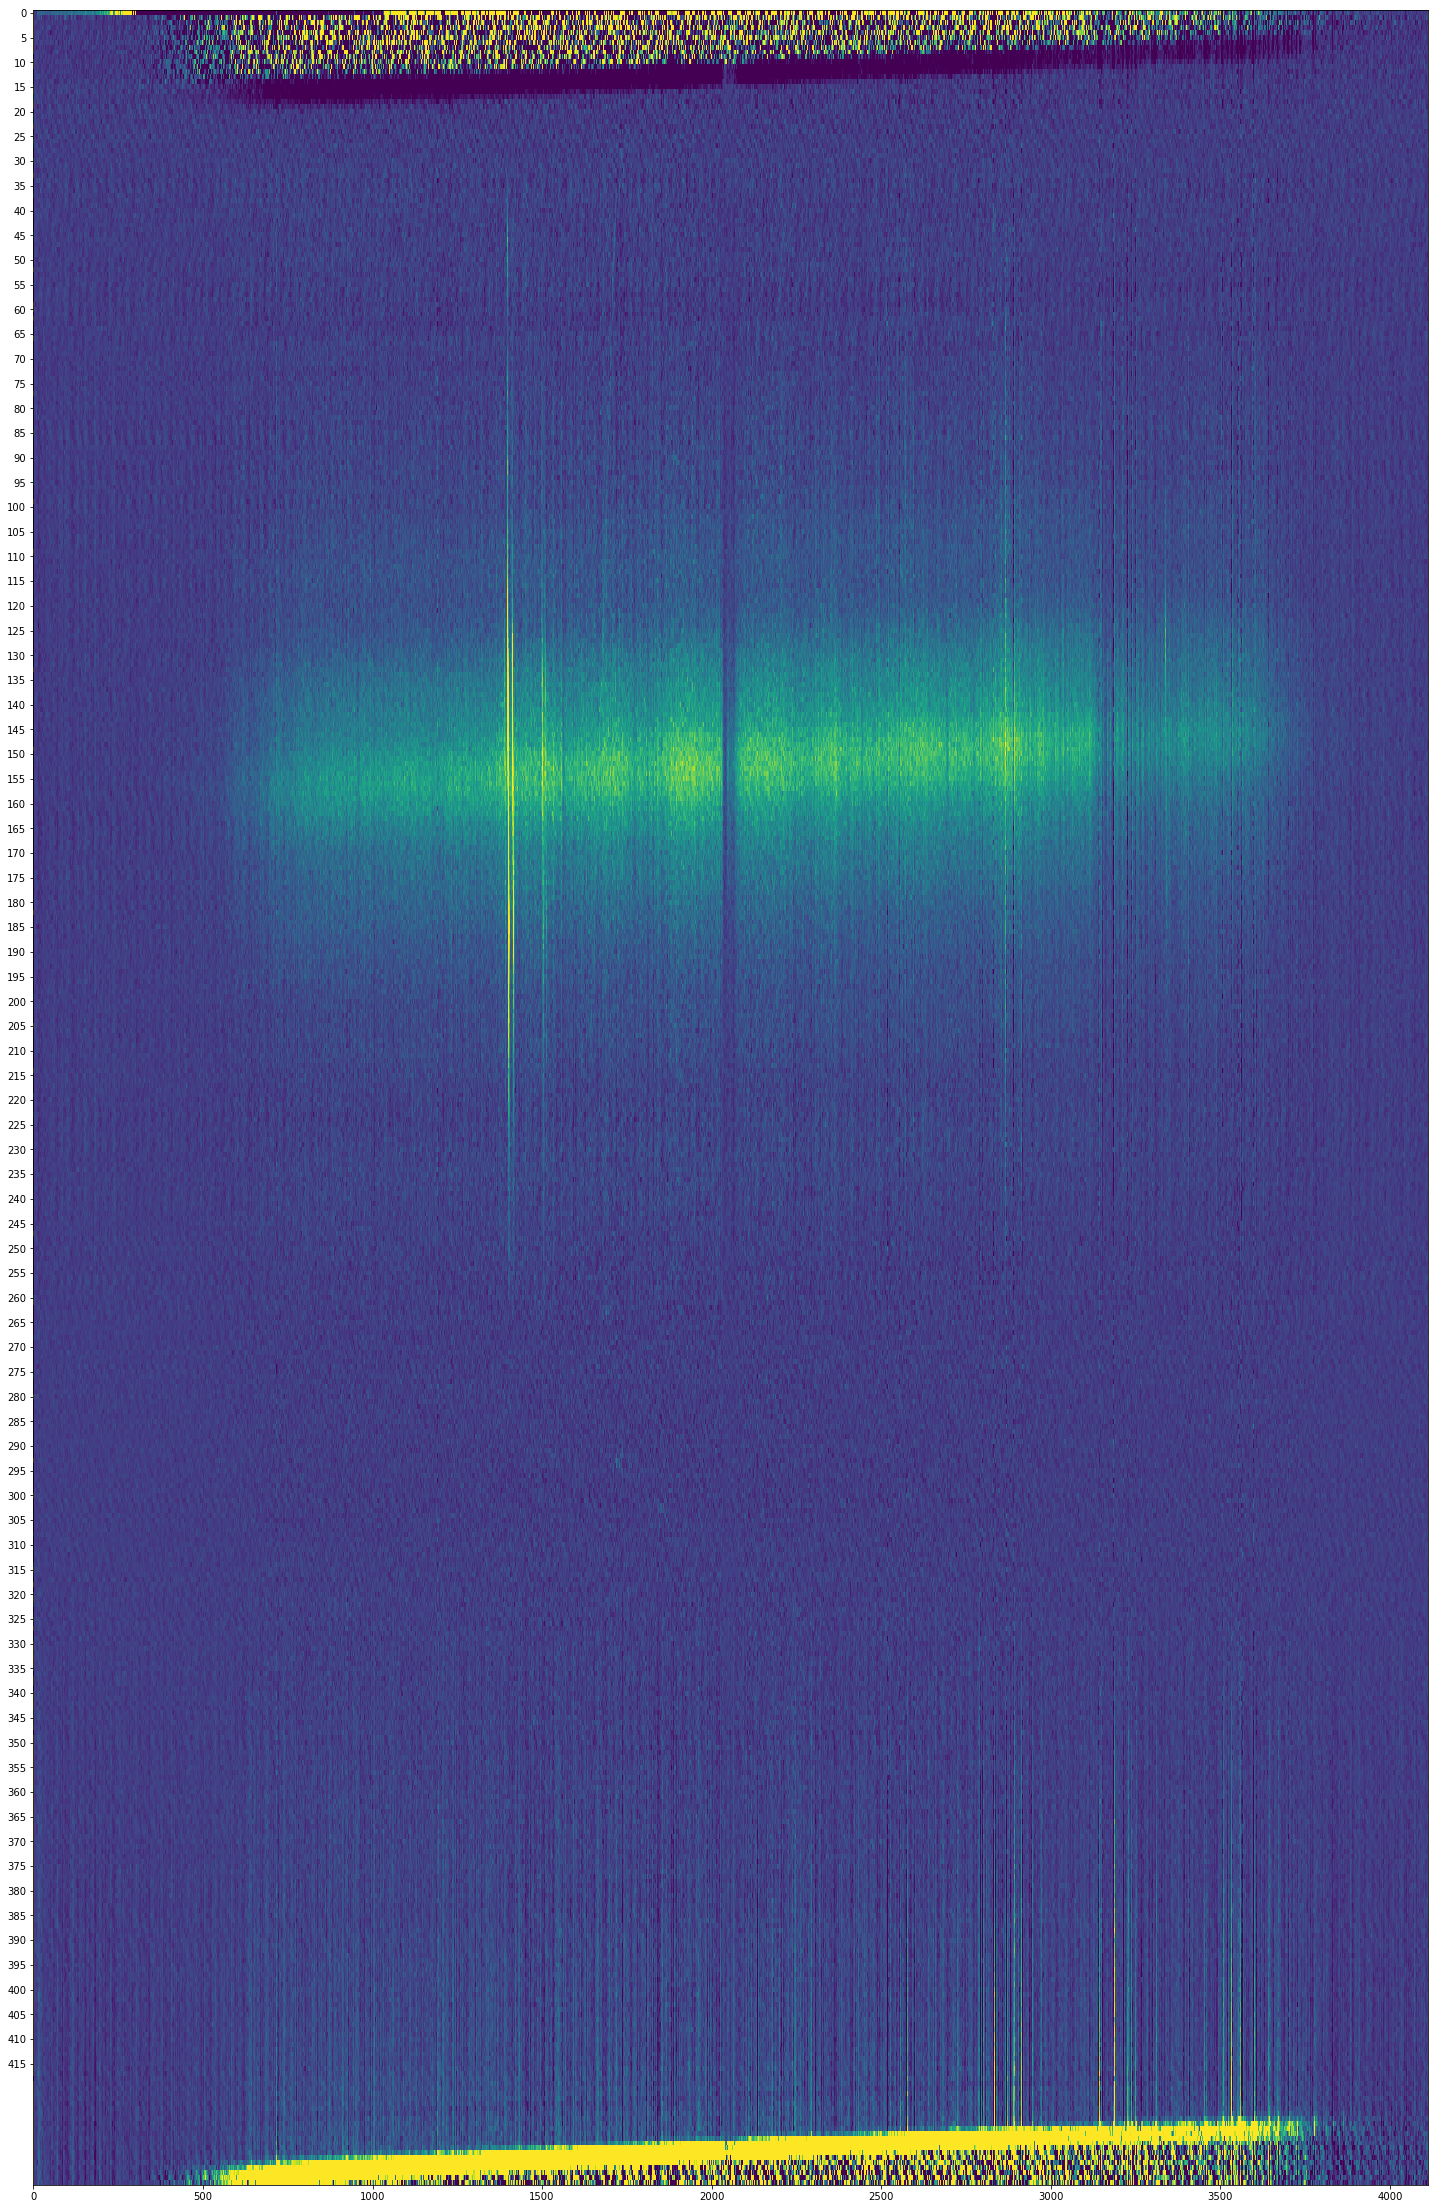

In [6]:
mydata=subimg2.data
vmin=-10
vmax=45
plt.figure(figsize=(25,40))

#instead of show_image function at top, doing this to show subtracted image

import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
plt.yticks(np.arange(0,420,5))
plt.imshow(mydata,aspect='auto',interpolation='nearest',vmin=vmin,vmax=vmax)

In [7]:
print(subimg2.data[::][0])

[ -6.35448395e+01   6.67014764e+01  -8.01993183e+02 ...,  -1.46522451e-01
  -3.74183006e-01  -1.10346141e+00]


In [8]:
subimg2.header
subimg2.data # flux is horiz.rows, wl is vertical columns

array([[ -6.35448395e+01,   6.67014764e+01,  -8.01993183e+02, ...,
         -1.46522451e-01,  -3.74183006e-01,  -1.10346141e+00],
       [ -6.56337357e+01,   6.85343634e+01,  -7.90691730e+02, ...,
          1.70647291e+00,   1.98860936e+00,   4.23329582e+00],
       [ -5.51667099e+01,   5.67780002e+01,  -7.71579219e+02, ...,
         -2.78473796e+00,  -4.65703081e+00,   7.35373758e-01],
       ..., 
       [ -5.85333640e+02,   4.28705913e+02,  -2.65243480e+03, ...,
          9.92516961e+00,   6.84470260e+00,  -4.45980143e+00],
       [ -7.38228216e+02,   4.29337799e+02,  -2.68054492e+03, ...,
          2.36865255e+00,  -5.99797231e+00,   8.07396868e+00],
       [ -7.28277178e+02,   4.07482835e+02,  -2.72690625e+03, ...,
          3.02872143e+00,  -2.94687367e+00,   1.84332008e+00]])

In [9]:
np.shape(comb2.data)

(440, 4114)

In [10]:
subimg2.data
#comb2

array([[ -6.35448395e+01,   6.67014764e+01,  -8.01993183e+02, ...,
         -1.46522451e-01,  -3.74183006e-01,  -1.10346141e+00],
       [ -6.56337357e+01,   6.85343634e+01,  -7.90691730e+02, ...,
          1.70647291e+00,   1.98860936e+00,   4.23329582e+00],
       [ -5.51667099e+01,   5.67780002e+01,  -7.71579219e+02, ...,
         -2.78473796e+00,  -4.65703081e+00,   7.35373758e-01],
       ..., 
       [ -5.85333640e+02,   4.28705913e+02,  -2.65243480e+03, ...,
          9.92516961e+00,   6.84470260e+00,  -4.45980143e+00],
       [ -7.38228216e+02,   4.29337799e+02,  -2.68054492e+03, ...,
          2.36865255e+00,  -5.99797231e+00,   8.07396868e+00],
       [ -7.28277178e+02,   4.07482835e+02,  -2.72690625e+03, ...,
          3.02872143e+00,  -2.94687367e+00,   1.84332008e+00]])

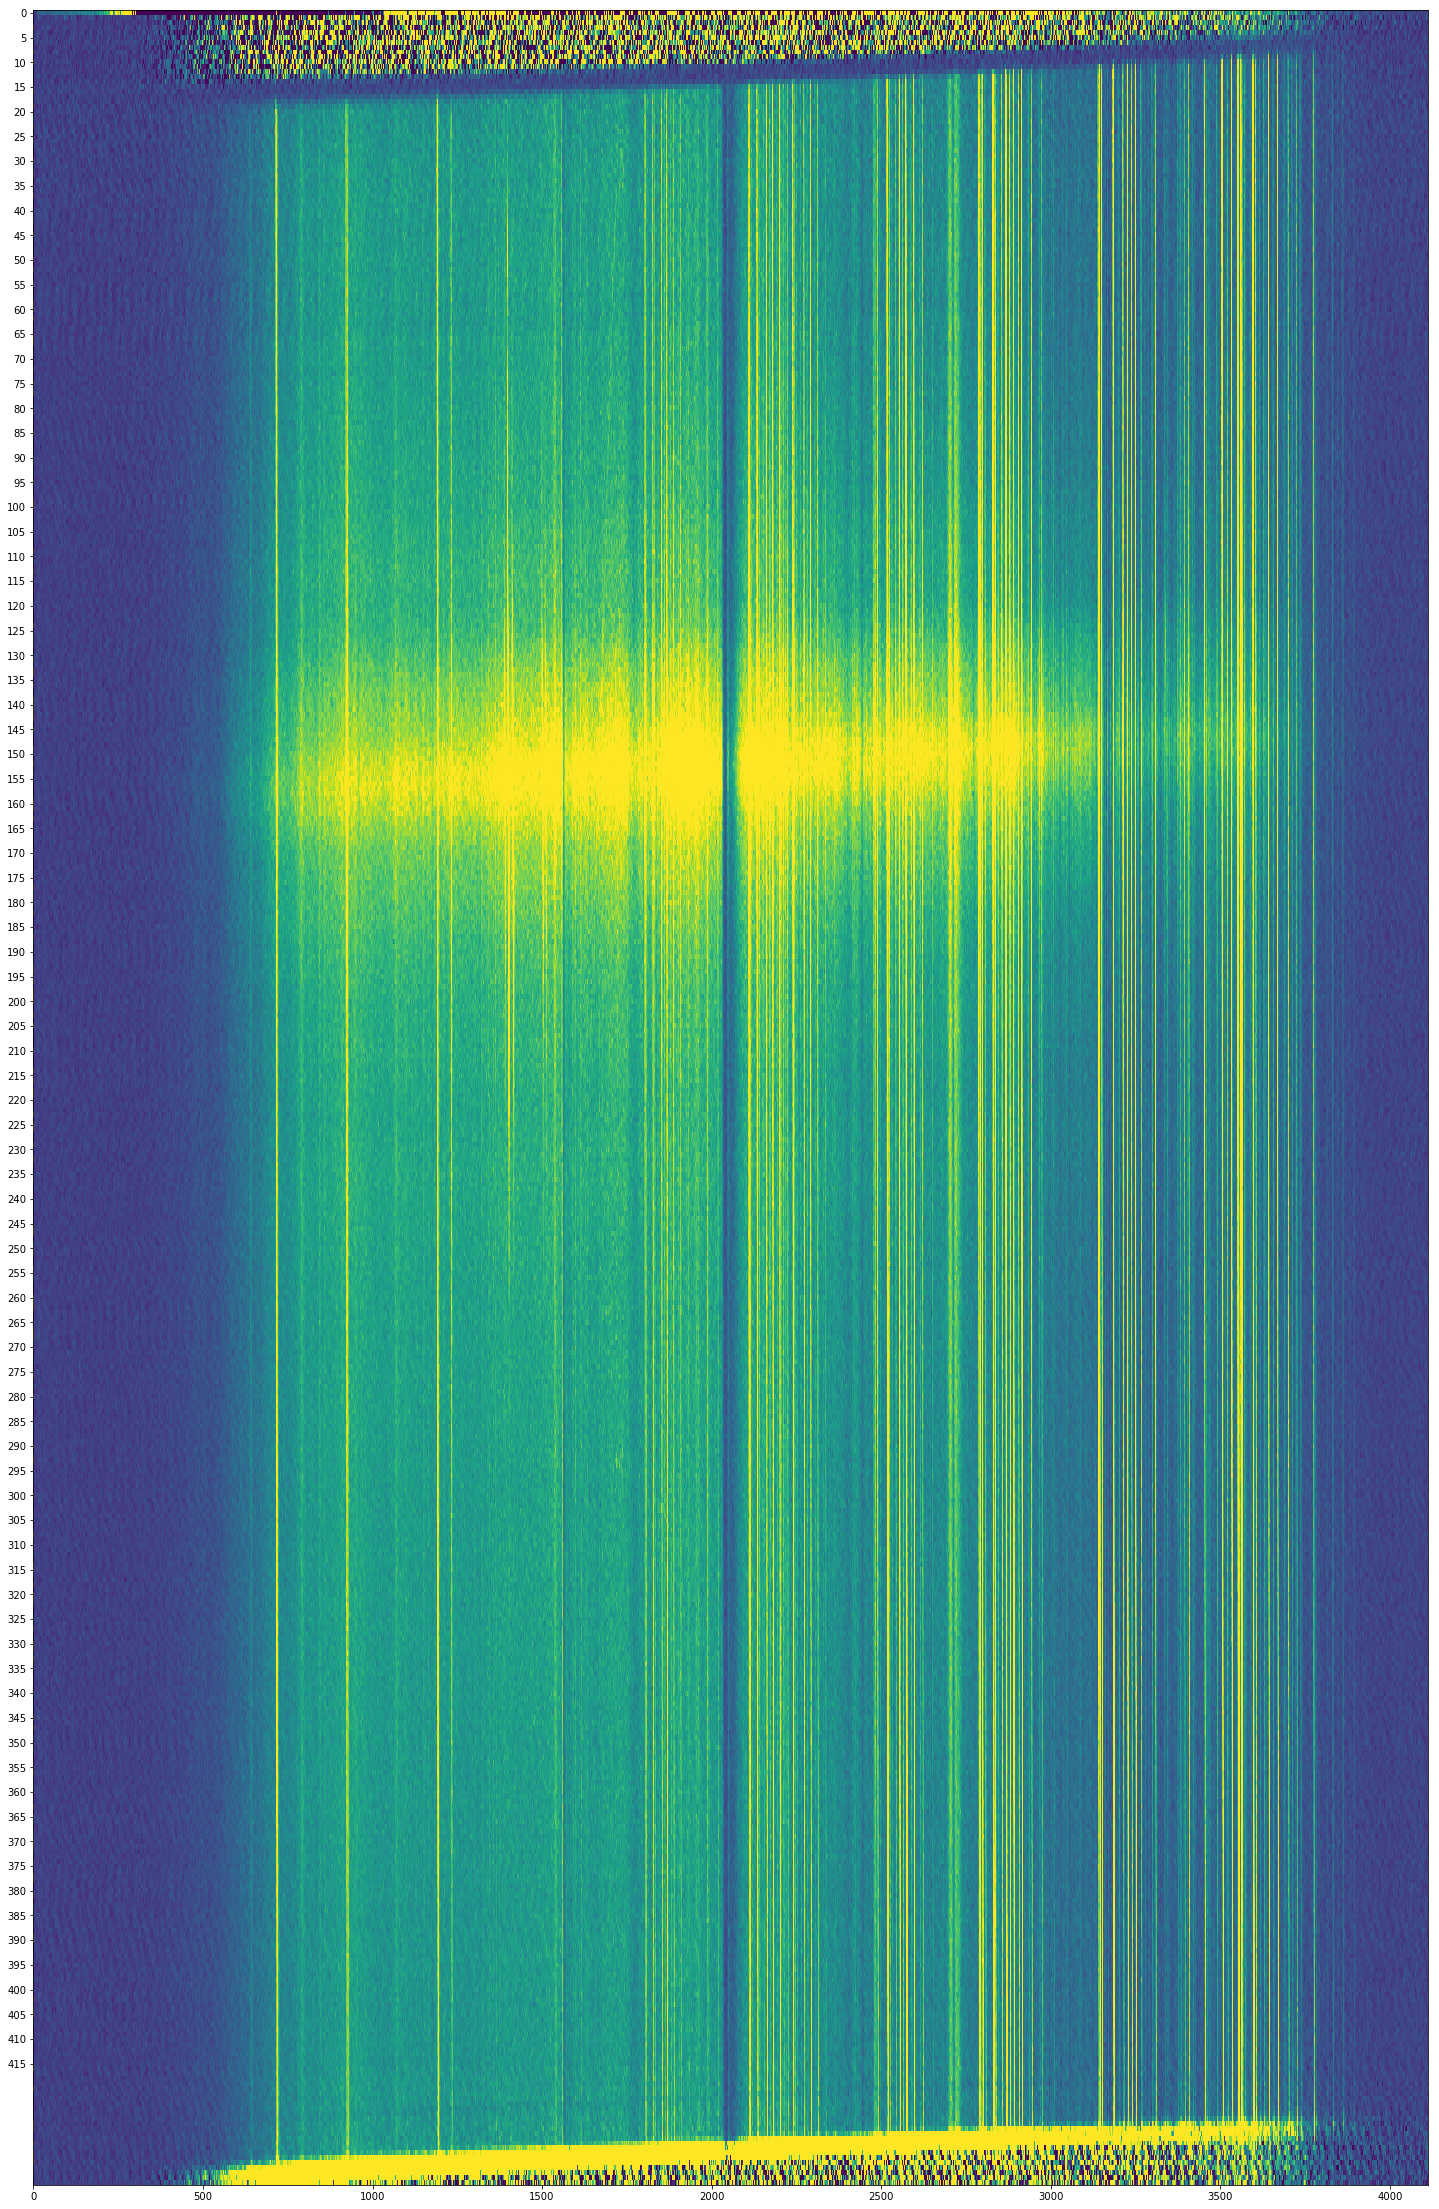

In [11]:
mydata=comb2.data
vmin=-10
vmax=45
plt.figure(figsize=(25,40))


#import matplotlib.ticker as plticker

#loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
#ax.xaxis.set_major_locator(loc)
plt.yticks(np.arange(0,420,5))

#fig, ax = plt.subplots()

#ax.plot(mydata)
plt.imshow(mydata,aspect='auto',interpolation='nearest',vmin=vmin,vmax=vmax)

In [12]:
 def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way

        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis

        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)

        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')

        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5

        return spec, unc

# ERIK------------------------MAYBE START HERE????

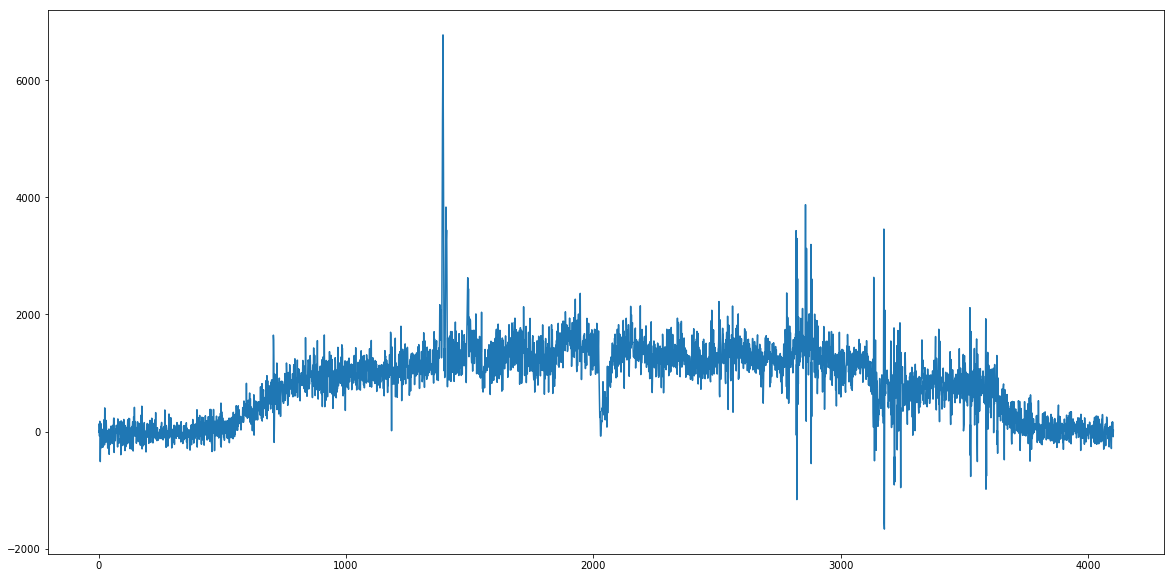

In [13]:
#skipping applying dispersion solution b/c irrelevant to this type of test

specaps=(35,260)
tspec_1d, unc = extract_spectrum('red',subimg2,specaps)
tspec_1d=tspec_1d[10::] #cutting off fringe edges of detector
plt.figure(figsize=(20,10))
plt.plot(tspec_1d)

In [151]:
np.shape(tspec_1d)
tspec_1d_wl= np.arange(0,len(tspec_1d),1)
data = Table([tspec_1d,tspec_1d_wl],names=('flux','wl'))
a=np.where(data['flux']==np.max(data['flux']))
c=data[a]
c

flux,wl
float64,int64
6769.42669983,1392


this is flux data shape: (226, 4104)


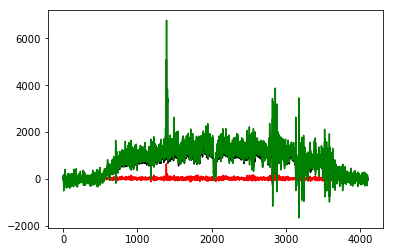

In [152]:
#apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
specaps=(35,260)

aperature=(35,260)
flux_data=[]
apslc = np.arange(aperature[0],aperature[1]+1,1)
#print (apslc) #as expected, +1 so doesnt cut off last value
for i in apslc:
    spec = np.sum(subimg2.data[aperature[0]:i], axis=0)
    spec = spec[10::] #chops first 10 flux values in spectral direction-crazy osscillations
    flux_data.append(spec)
    
#need to find a way to sum over diff ranges of apslc 
print('this is flux data shape:',np.shape(flux_data))
#print('this is the flux data:',flux_data)
#spec = spec[10::]
plt.plot(flux_data[45],color='r')
plt.plot(flux_data[145],color='k')
plt.plot(flux_data[225],color='g')




In [153]:

#np.max(flux_data)#6769.4266998279936
#len(apslc)/2 #113 #this is center of target flux ie galaxy core WARNING --
#WARNING -- galaxy core needith be exactly at the center, should be more robust and 
#do a max search to id the core when refining code 


tspec_range=np.arange(0,len(flux_data),1)
spatially_below_core=[]
spatially_above_core=[]
for i in tspec_range:
    if i <= 112:
        spatially_below_core.append(flux_data[i])
    else:
        #print(i)
        spatially_above_core.append(flux_data[i])

#np.shape(flux_data[112::])      
        
len(spatially_above_core)#113
len(spatially_below_core)#113
#len(tspec_range)#226

113

In [154]:
np.shape(spatially_above_core)#(113, 4104) (spatial row above core(ie radius), wl)
m=np.max(spatially_above_core[5])
#plt.plot(spatially_above_core)

#this will find the wl of the max value....in this case wl of max is halpha

for i, j in enumerate(spatially_above_core[5]):
    if j == np.max(spatially_above_core[5]):
        halpha = i
        print(halpha)
#NOTE this isnt real wl in angstroms, i havent applied ds to this test to get script right
m
#spatially_above_core[5][1390]

1390


4249.6263546611726

In [155]:
#isolating halpha emissions in each spatial row

halpha_above=[]
halpha_below=[]
radiusrange=np.arange(0,113,1)
for i in radiusrange:
    idk=np.sum(spatially_above_core[i][1388:1392])#summing 3 wls around halpha
    halpha_above.append(idk)
    idk2 = np.sum(spatially_below_core[i][1388:1392])#somehow need to generalize wl ranges to add...seek out max..
    halpha_below.append(idk2)
    
np.shape(halpha_below)#113 spatial rows of halpha flux

(113,)

In [156]:
#need to reverse below side to get galaxy core as the origin


radius_above=[]
radius_below=[]
for i in radiusrange:
    sumr = np.sum(halpha_above[i::]) #summing each row to the end
    radius_above.append(sumr)
    sumr2 = np.sum(halpha_above[i::])
    radius_below.append(sumr2)
    #list.reverse(radius_below)



#above isnt what i want...maybe this whole cell isnt necessary
np.shape(radius_below)

(113,)

In [157]:
radius_below = np.array(radius_below)
type(radius_below)

numpy.ndarray

In [158]:
#trying to invert array so 
#that galaxy core is at center of graphs

radius_below = np.flip(radius_below,axis=0)
radius_below

array([   18967.73413433,    37935.35055522,    56909.93299595,
          75880.33887551,    94845.06479808,   113816.10099063,
         132793.46363931,   151769.73088599,   170747.60571685,
         189729.83365171,   208705.04818351,   227667.59458316,
         246624.8368377 ,   265577.98340104,   284526.78789667,
         303470.35197955,   322409.81852584,   341338.68897456,
         360266.21008366,   379198.36193254,   398124.66141232,
         417048.40495713,   435966.82242623,   454878.04036741,
         473782.87809961,   492682.07924748,   511569.55489987,
         530454.31394436,   549326.26239562,   568191.90012507,
         587046.03858669,   605899.94051517,   624745.34734257,
         643581.67248191,   662407.96583021,   681222.09906573,
         700024.79528989,   718823.2374184 ,   737617.61589183,
         756394.11964808,   775165.75170621,   793938.42801213,
         812696.65108078,   831442.27412814,   850178.88395149,
         868896.42814846,   887600.56977

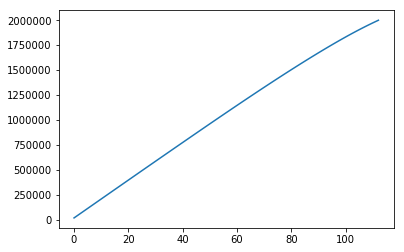

In [159]:
#do the pixel plate scale too!!!!!!!!!!!!!!!!!!!!!!!!!


from astropy import units as u
r_in_arcmin = 1*u.arcmin# radial distance of measurement from centre of object in arcmin
distance = 5*u.Mpc # distance of object from us
r_in_kpc = (r_in_arcmin/u.rad*distance).to("kpc") # radial distance of measurement from centre of object in kpc

redplatescale = 0.293*u.arcsec/u.pixel
blueplatescale = 0.389*u.arcsec/u.pixel

dbsp_pix_equiv = u.pixel_scale(redplatescale)
r_in_pixel = 2*u.pixel
r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)


plt.plot(radius_below)

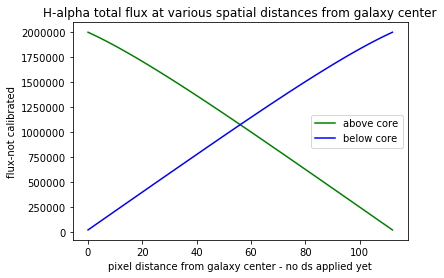

In [160]:
plt.title('H-alpha total flux at various spatial distances from galaxy center')
plt.ylabel('flux-not calibrated')
plt.xlabel('pixel distance from galaxy center - no ds applied yet')
above, = plt.plot(radius_above, color='g',label='above core')
below, = plt.plot(radius_below, color='b',label='below core')
plt.legend(handles=[above,below])


In [18]:
#whole cell of tests

#test if slices mean what i think they mean
aps = [1,3]

dt = ([[1,2,3],
     [4,5,6],
     [7,8,9],
    [10,11,12]])


aps = [1,3]

dt = ([[1,2,3],
     [4,5,6],
     [7,8,9],
    [10,11,12]])aslice = np.arange(aps[0],aps[1]+1,1) #target spatial row numbers in an array #1,2,3
mydata=[] #empty list to collect outputs
for i in aslice: #doing stuff for each spatial row of the target
    #print(i)
    test = np.sum(dt[aps[0]:i], axis=0) #summing each spatial row of target
    mydata.append(test) #collecting all outputs


    ntest = np.sum(dt[2],axis=0)
mydata#so each of these arrays is a 1D spec out to total 
dt[1::]


#testing is sum axis is what i think
testing=np.sum([[0, 1], [0, 5]], axis=0)
testing

dt[aps[0]:1]#empty so first array of sums will always be zero but thats okay, just remember to cut it off
#dt[aps[0]] #4,5,6

[[4, 5, 6], [7, 8, 9], [10, 11, 12]]

array([0, 6])

[]

# END OF TEST

In [21]:
#len(comb.data) #440
#len(comb.data[0]) #4114
np.shape(comb.data) #(440,4114)

(440, 4114)

In [22]:
data_slice = comb.data[1][1999]
data_slice

25.824504017342026

In [23]:
data=comb.data
data

array([[ -8.11022338e-01,  -1.07129855e+00,  -1.29068135e+00, ...,
          9.59993461e-01,   9.63950343e-01,  -5.40156495e-02],
       [ -5.74223461e+00,   3.81096651e+00,  -5.39335075e+00, ...,
          2.80427601e+00,   3.33067000e+00,   5.28431249e+00],
       [  1.90260035e+00,  -4.91364753e+00,  -1.59477259e+00, ...,
         -1.69558546e+00,  -3.31108325e+00,   1.78794635e+00],
       ..., 
       [  1.52560364e+02,   1.40634585e+01,   8.70192376e+00, ...,
          1.31505721e+01,   6.05276324e+00,  -4.14973174e+00],
       [  5.61820787e+00,   1.00408333e+01,   4.60068676e+00, ...,
          5.61252744e+00,  -6.80362796e+00,   8.37906864e+00],
       [  2.15417900e+01,  -1.64862712e+01,  -1.76615644e+01, ...,
          6.29113097e+00,  -3.76628598e+00,   2.14343533e+00]])

In [24]:
data2=data.transpose()
data2#this is the struccture matrix i want aka each first array (larger) is column
#so that will match the sky emission columns

array([[ -8.11022338e-01,  -5.74223461e+00,   1.90260035e+00, ...,
          1.52560364e+02,   5.61820787e+00,   2.15417900e+01],
       [ -1.07129855e+00,   3.81096651e+00,  -4.91364753e+00, ...,
          1.40634585e+01,   1.00408333e+01,  -1.64862712e+01],
       [ -1.29068135e+00,  -5.39335075e+00,  -1.59477259e+00, ...,
          8.70192376e+00,   4.60068676e+00,  -1.76615644e+01],
       ..., 
       [  9.59993461e-01,   2.80427601e+00,  -1.69558546e+00, ...,
          1.31505721e+01,   5.61252744e+00,   6.29113097e+00],
       [  9.63950343e-01,   3.33067000e+00,  -3.31108325e+00, ...,
          6.05276324e+00,  -6.80362796e+00,  -3.76628598e+00],
       [ -5.40156495e-02,   5.28431249e+00,   1.78794635e+00, ...,
         -4.14973174e+00,   8.37906864e+00,   2.14343533e+00]])

In [25]:
#testing

test = ([[1,2,3,4,5],[6,7,8,9,0],[10,20,30,40,50]])
np.shape(test)

(3, 5)

In [26]:
#testing
test2=np.reshape(test,(5,3))
#test2
type(test2)

numpy.ndarray

In [27]:
#testing
test=np.array(test)
type(test)
test.transpose()

array([[ 1,  6, 10],
       [ 2,  7, 20],
       [ 3,  8, 30],
       [ 4,  9, 40],
       [ 5,  0, 50]])

In [28]:
#testing
test4=test[2:]
test4
#model_x = np.linspace(0, len(test4), len(test4)*10)
#plt.plot(model_x)

array([[10, 20, 30, 40, 50]])

In [29]:
data3=data2[2000] #this is around a sky line

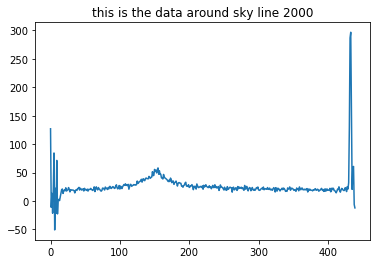

In [30]:
plt.plot(data3)
plt.title('this is the data around sky line 2000')

In [31]:
#model_x = np.linspace(0, len(data2), len(data2)*10)
#plt.plot(model_x)
mymodel= modeling.models.Polynomial1D(7)
#uses these vals from above skyaps=[(30,110),(180,400)] 
subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
#maybe=subimg
type(subimg)
#np.shape(subimg)

reduce_dblspec.DoubleSpecImage

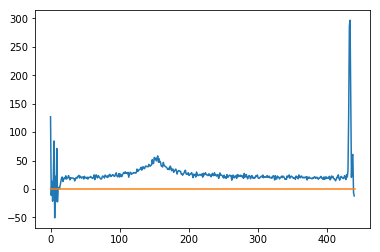

In [32]:
#model=np.array(subimg.data)
#plt.plot(model)
model_data=subimg.data.transpose()
#np.shape(model_data)
model_data2=model_data[2000] #isolating column along a sky emission, model fitted data
fitter = modeling.fitting.LevMarLSQFitter()
plt.plot(data3)
#type(model_data)
model_x = np.linspace(0, len(data3), len(data3)*10) #this has more points so need to go over data not with it
plt.plot(model_x,mymodel(model_x))

In [33]:
#mymodel(test)
np.shape(model_data2)

(440,)

In [34]:
modeling.models.Polynomial1D(7)(test)

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

## TARGET: SD-2  
### SKY LINE 2000

model_x (440,)
new_model ()


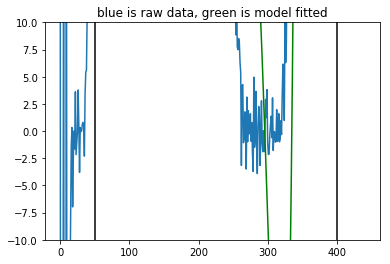

In [35]:
###SKY LINE
model_data2=model_data[2000] #isolating column along a sky emission, model fitted data

skyaps=[(30,110),(180,400)] #used from 5/19/17 night for sd-2
x = np.linspace(0, len(model_data2), len(model_data2)*10) #(4400,)
model_x = np.arange(0,len(model_data2))
y = model_data2
#yy = np.array([y, y])
p2 = modeling.models.Polynomial1D(6)#, n_models=1)

#pfit = fitting.LinearLSQFitter()
pfit = modeling.fitting.LevMarLSQFitter()

#for i in yy:
#    print(i)
print('model_x',np.shape(model_x))

#print(np.shape(yy))
new_model = pfit(p2, model_x[50:400], y[50:400])#, yy)#, yy)
#print(new_model)
print('new_model',np.shape(new_model))
#plt.xticks(x)
plt.title('blue is raw data, green is model fitted')

plt.plot(model_x,y)#(model_x,y)
plt.plot(x,new_model(x),color='g')#(x,new_model(x),color='g')
plt.ylim(-10,10)
plt.axvline(50,color='k')
plt.axvline(400,color='k')

In [36]:
len(model_x)

440

In [37]:
p2

<Polynomial1D(6, c0=0.0, c1=0.0, c2=0.0, c3=0.0, c4=0.0, c5=0.0, c6=0.0)>

In [38]:
new_model

<Polynomial1D(6, c0=5592.246837941313, c1=-257.50458628617616, c2=4.42008868807051, c3=-0.03527549844823839, c4=0.00014339527975830297, c5=-2.8958505209189406e-07, c6=2.3109959279424218e-10)>

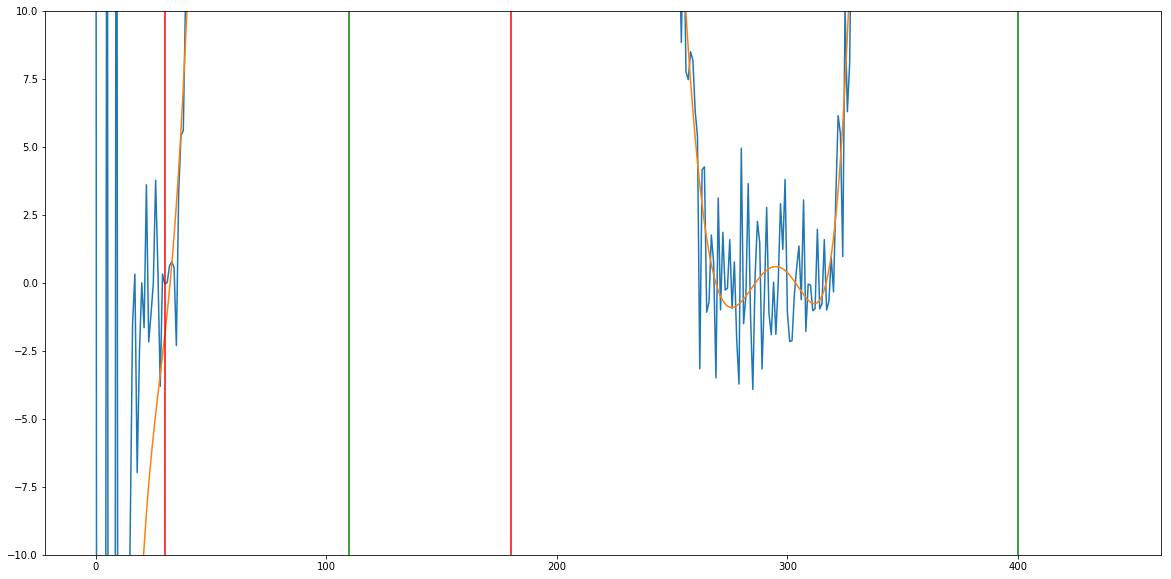

In [39]:
#from erik
p2 = modeling.models.Polynomial1D(9,c0=1)#, n_models=1)
plt.figure(figsize=(20,10))



data = model_data2  # from your notebook
x_data = np.arange(len(data))
x_model = np.linspace(0, len(data), 10*len(data))

xfits = []
yfits = []
for lower, upper in skyaps:
    xfits.append(x_data[lower:upper])
    yfits.append(data[lower:upper])
xfit = np.concatenate(xfits)
yfit = np.concatenate(yfits)
new_model = pfit(p2, xfit.astype(float), yfit)

plt.plot(x_data, data) # should be the same as plt.plot(data)
plt.plot(x_model, new_model(x_model))
plt.ylim(-10,10)
new_model
for lower,upper in skyaps:
    plt.axvline(lower,color='r')
    plt.axvline(upper,color='g')

In [40]:
#yfit

In [41]:
#x = np.linspace(0, len(model_data2), len(model_data2)*10) #(4400,)
#model_x = np.arange(0,len(model_data2))
#y = model_data2
#p2 = modeling.models.Polynomial1D(3)
#pfit = modeling.fitting.LevMarLSQFitter()

#new_model = pfit(p2, x, y)
#print(p2(y)) ## all zeros, this is the problem

#plt.plot(model_x,p2(y))

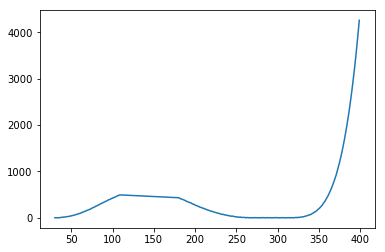

In [42]:
plt.plot(xfit,yfit)

In [43]:
x_model

array([  0.00000000e+00,   1.00022732e-01,   2.00045465e-01, ...,
         4.39799955e+02,   4.39899977e+02,   4.40000000e+02])

### DIFF SKY LINE 3173

model_x (440,)
new_model ()


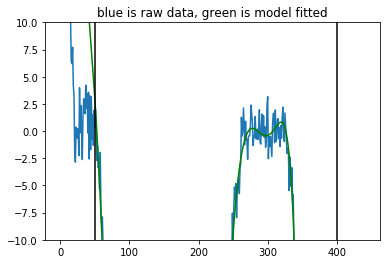

In [44]:
#checking diff sky line:


model_data3=model_data[3173]

skyaps=[(30,110),(180,400)] 
x = np.linspace(0, len(model_data3), len(model_data3)*10) #(4400,)
model_x = np.arange(0,len(model_data3))
y = model_data3
#yy = np.array([y, y])
p2 = modeling.models.Polynomial1D(7)#, n_models=1)

#pfit = fitting.LinearLSQFitter()
pfit = modeling.fitting.LevMarLSQFitter()

#for i in yy:
#    print(i)
print('model_x',np.shape(model_x))

#print(np.shape(yy))
new_model = pfit(p2, model_x[50:400], y[50:400])#, yy)#, yy)
#print(new_model)
print('new_model',np.shape(new_model))
#plt.xticks(x)
plt.title('blue is raw data, green is model fitted')

plt.plot(model_x,y)#(model_x,y)
plt.plot(x,new_model(x),color='g')#(x,new_model(x),color='g')
plt.ylim(-10,10)
plt.axvline(50,color='k')
plt.axvline(400,color='k')

### NO SKY LINE

model_x (440,)
new_model ()


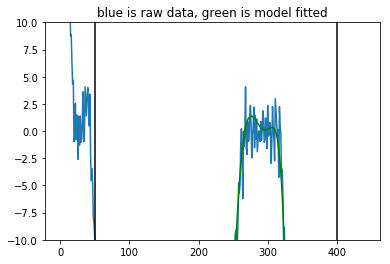

In [45]:
#checking a place with no sky emissions:

model_data4=model_data[3077]

skyaps=[(30,110),(180,400)] 
x = np.linspace(0, len(model_data4), len(model_data4)*10) #(4400,)
model_x = np.arange(0,len(model_data4))
y = model_data4
#yy = np.array([y, y])
p2 = modeling.models.Polynomial1D(9)#, n_models=1)

#pfit = fitting.LinearLSQFitter()
pfit = modeling.fitting.LevMarLSQFitter()

#for i in yy:
#    print(i)
print('model_x',np.shape(model_x))

#print(np.shape(yy))
new_model = pfit(p2, model_x[50:400], y[50:400])#, yy)#, yy)
#print(new_model)
print('new_model',np.shape(new_model))
#plt.xticks(x)
plt.title('blue is raw data, green is model fitted')

plt.plot(model_x,y)#(model_x,y)
plt.plot(x,new_model(x),color='g')#(x,new_model(x),color='g')
plt.ylim(-10,10)
plt.axvline(50,color='k')
plt.axvline(400,color='k')

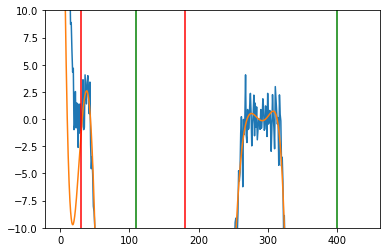

In [46]:
#checking for any diff from my code above:

#from erik
p2 = modeling.models.Polynomial1D(9,c0=1)#, n_models=1)


data = model_data4 
x_data = np.arange(len(data))
x_model = np.linspace(0, len(data), 10*len(data))

xfits = []
yfits = []
for lower, upper in skyaps:
    xfits.append(x_data[lower:upper])
    yfits.append(data[lower:upper])
xfit = np.concatenate(xfits)
yfit = np.concatenate(yfits)
new_model = pfit(p2, xfit.astype(float), yfit)

plt.plot(x_data, data) # should be the same as plt.plot(data)
plt.plot(x_model, new_model(x_model))
plt.ylim(-10,10)
new_model
for lower,upper in skyaps:
    plt.axvline(lower,color='r')
    plt.axvline(upper,color='g')

# doing sky subtract & extract spec in 2 steps instead of 1

In [47]:
#from reduce_dblspec
def subtract_sky(self, skyapertures, skymodel=None):
        """
        Subtracts sky from the 2D image along the given apertures.

        Note that this currently assumes fitted sky has no uncertainty, which is
        probably only true with large enough sky apertures

        Parameters
        ----------
        skyapertures : list of 2-tuples or slice objects
            A list of 2-tuples (lower, upper) or slices, specifying the
            sections along the spatial direction to define the sky.
        skymodel : astropy.modeling.model
            The model to fit, or None to just subtract the mean

        Returns
        -------
        newimg : DoubleSpecImage
            A new 2D image with the sky subtracted
        fittedmodels : None or list of models
            The models fit along the row, or None if `skymodel` is None
        """
        from astropy import modeling

        apslcs = []
        for ap in skyapertures:
            if isinstance(ap, slice):
                apslcs.append(ap)
            else:
                apslcs.append(slice(*ap))

        if self.side == 'red':
            d = self.data.T  # first axis should be dispersion
        elif self.side == 'blue':
            d = self.data
        else:
            raise ValueError("unrecognized side " + str(self.side))

        subeds = []
        if skymodel:
            xs = np.arange(d.shape[1])
            xaps = np.concatenate([xs[ap] for ap in apslcs])

            if isinstance(skymodel, modeling.models.Linear1D):
                fitter = _linfit
            else:
                fitter = modeling.fitting.LevMarLSQFitter()#NonLinearLSQFitter()

            fitmodels = []
            for cut in d:
                yaps = np.concatenate([cut[ap] for ap in apslcs])
                fitmodels.append(fitter(skymodel, xaps, yaps))
                y = yaps
                subeds.append(cut - fitmodels[-1](xs))
        else:
            fitmodels = None
            for cut in d:
                yaps = np.concatenate([cut[ap] for ap in apslcs])
                subeds.append(cut - np.mean(yaps))

        # get the right spatial/dispersion axis convention
        if self.side == 'red':
            newdata = np.array(subeds).T
        elif self.side == 'blue':
            newdata = np.array(subeds)
        else:
            raise ValueError('unrecognized side '+str(self.side))

        res = DoubleSpecImage(newdata, self.unc, self.header,
                              self.side)
        pd = list(self.processingdone)
        pd.append('sky sub')
        res.processingdone = tuple(pd)

        return res, fitmodels

In [48]:
def extract_spectrum(self, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way

        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis

        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)

        if self.side == 'red':
            d = self.data
        elif self.side == 'blue':
            d = self.data.T
        else:
            raise ValueError('unrecognized side ' + str(self.side))

        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5

        return spec, unc